## Naive Bayes on Political Text
### Halee Staggs
#### CHATGpt4.o was used as a tool for this assignment. All code was quality checked. 

In [156]:
# Import libraries and functions
import sqlite3
import nltk
import random
import numpy as np
from collections import Counter, defaultdict
import pandas as pd
import os
import re
import numpy as np
from nltk.corpus import stopwords
from string import punctuation

# Load stopwords
sw = stopwords.words("english")

# Add any additional import statements you need here
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score
from imblearn.metrics import specificity_score, sensitivity_score

## Setup Functions

In [88]:
# Function to creat clean data
def clean_and_tokenize(text):
    # Explicitly remove special characters
    additional_punctuation = "’‘“”!@#$%^&*()<>›?/\{}[]-_–+=`~;:"  

    # Replace additional punctuation with empty string
    for char in additional_punctuation:
        text = text.replace(char, "")
        
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Split on whitespace and fold to lowercase
    words = word_tokenize(text.lower())
    
    # Remove stopwords
    words = [word for word in words if word not in sw]
    
    return words

## Look at database contents. There is only 1 table.

In [61]:
# Open connection to database
convention_db = sqlite3.connect(r"2020_Conventions.db")
convention_cur = convention_db.cursor()

# Query to list all tables
convention_cur.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch and print all table names
tables = convention_cur.fetchall()
for table in tables:
    print(table[0])

# Close the connection
convention_db.close()

conventions


### Look at a sample of data from the conventions table. There are 8 columns and just over 2500 speeches.

In [62]:
# Open connection to database
convention_db = sqlite3.connect(r"2020_Conventions.db")
convention_cur = convention_db.cursor()

# Query to select all records from the 'conventions' table
convention_cur.execute("SELECT * FROM conventions")

# Fetch the records
rows = convention_cur.fetchall()

# Get the column names
column_names = [description[0] for description in convention_cur.description]

# Create a DataFrame from the rows and column names
df = pd.DataFrame(rows, columns=column_names)

# Close the connection
convention_db.close()

# Display the DataFrame
print(df)

           party  night                  speaker  speaker_count      time  \
0     Democratic      4                  Unknown              1     00:00   
1     Democratic      4                Speaker 1              1     00:33   
2     Democratic      4                Speaker 2              1     00:59   
3     Democratic      4         Kerry Washington              1     01:07   
4     Democratic      4           Bernie Sanders              1     01:18   
...          ...    ...                      ...            ...       ...   
2536  Democratic      3             Nancy Pelosi             11  02:43:33   
2537  Democratic      3               Speaker 69              1  02:43:39   
2538  Democratic      3             Barack Obama             24  02:43:49   
2539  Democratic      3  Archbishop Elpidophoros              1  02:44:24   
2540  Democratic      3               Speaker 70              1  02:45:33   

                                                   text text_len  \
0     S

### Part 1: Exploratory Naive Bayes

We'll first build a NB model on the convention data itself, as a way to understand what words distinguish between the two parties. This is analogous to what we did in the "Comparing Groups" class work. First, pull in the text 
for each party and prepare it for use in Naive Bayes.  

In [63]:
convention_data = []

# Open connection to database
convention_db = sqlite3.connect(r"2020_Conventions.db")
convention_cur = convention_db.cursor()
query_results = convention_cur.execute(
                            '''
                            SELECT text, party FROM conventions
                            ''')

# Fetch the records
rows = query_results.fetchall()

# Process each row
for row in rows:
    text, party = row

    # Apply cleaning steps to text data
    text = clean_and_tokenize(text) 

    # Add clean data to the list
    convention_data.append((text, party))

# Convert list to DataFrame
convention_text = pd.DataFrame(convention_data, columns=['text', 'party'])

# Close the connection
convention_db.close()

# Display the DataFrame
convention_text.head()

,text,party
0,"[skip, content, company, careers, press, freel...",Democratic
1,"[im, calling, full, session, 48th, quadrennial...",Democratic
2,"[every, four, years, come, together, reaffirm,...",Democratic
3,"[fight, perfect, union, fighting, soul, countr...",Democratic
4,"[must, come, together, defeat, donald, trump, ...",Democratic


Let's look at some random entries and see if they look right. 

In [64]:
# Get a random sample of 5 rows from the DataFrame
random_sample = convention_text.sample(n=5, random_state=42)
print(random_sample)

                                                   text       party
1558  [unlike, donald, trump, joe, biden, actually, ...  Democratic
134   [know, cant, take, democracy, granted, especia...  Democratic
1640  [theyre, learning, conquered, pandemic, stood,...  Democratic
1498  [factory, workers, ohio, faced, dangerous, con...  Democratic
1399  [together, nations, europe, experienced, 30, g...  Republican


If that looks good, we now need to make our function to turn these into features. In my solution, I wanted to keep the number of features reasonable, so I only used words that occur at least `word_cutoff` times. Here's the code to test that if you want it. 

In [65]:
# Get all tokens from the DataFrame
all_tokens = [token for sublist in convention_text['text'] for token in sublist]

# Create a frequency distribution of the tokens
word_dist = nltk.FreqDist(all_tokens)

# Define a word frequency cutoff
word_cutoff = 5

# Collect words that appear at least word_cutoff times
feature_words = {word for word, count in word_dist.items() if count >= word_cutoff}

# Make into dataframe
feature_words_df = pd.DataFrame(list(feature_words), columns=['feature_word'])

# Look at first 50 words
print(feature_words_df.head(25))

   feature_word
0      inspired
1       despair
2         maine
3          pass
4     dictators
5          tide
6      consider
7        pushed
8       shining
9         enemy
10      systems
11        sides
12      ceiling
13        30330
14      promote
15     expected
16         fair
17   lifesaving
18         warp
19     profound
20         town
21     lincolns
22  suppression
23       stayed
24         king


In [158]:
# Create function to identify if speeches contain the feature words identified above
def conv_features(text, fw) :
    # Initialize an empty dictionary to hold the feature words
    ret_dict = dict()
    
    # Iterate over the words in the list
    for word in text:
        # If the word is in the feature words set and not already in the dictionary
        if word in fw and word not in ret_dict:
            # Add the word to the dictionary with the value True
            ret_dict[word] = True
    
    return ret_dict

# Apply the function to the DataFrame
convention_text['fw'] = convention_text['text'].apply(lambda x: conv_features(x, feature_words))

# Display the DataFrame with feature words
print(convention_text[['text', 'fw']].head(10))

                                                text  \
0  [skip, content, company, careers, press, freel...   
1  [im, calling, full, session, 48th, quadrennial...   
2  [every, four, years, come, together, reaffirm,...   
3  [fight, perfect, union, fighting, soul, countr...   
4  [must, come, together, defeat, donald, trump, ...   
5  [donald, trump, wrong, president, country, eno...   
6  [dad, healthy, 65, year, old, preexisting, con...   
7  [us, carry, fight, justice, actions, would, le...   
8  [need, leadership, bring, us, back, together, ...   
9                           [next, president, right]   

                                                  fw  
0  {'skip': True, 'content': True, 'company': Tru...  
1  {'im': True, 'calling': True, 'full': True, 's...  
2  {'every': True, 'four': True, 'years': True, '...  
3  {'fight': True, 'perfect': True, 'union': True...  
4  {'must': True, 'come': True, 'together': True,...  
5  {'donald': True, 'trump': True, 'wrong': True,... 

In [67]:
# Display the DataFrame with feature words
convention_text[['text', 'fw']].head(10)

,text,fw
0,"[skip, content, company, careers, press, freel...","{'skip': True, 'content': True, 'company': Tru..."
1,"[im, calling, full, session, 48th, quadrennial...","{'im': True, 'calling': True, 'full': True, 's..."
2,"[every, four, years, come, together, reaffirm,...","{'every': True, 'four': True, 'years': True, '..."
3,"[fight, perfect, union, fighting, soul, countr...","{'fight': True, 'perfect': True, 'union': True..."
4,"[must, come, together, defeat, donald, trump, ...","{'must': True, 'come': True, 'together': True,..."
5,"[donald, trump, wrong, president, country, eno...","{'donald': True, 'trump': True, 'wrong': True,..."
6,"[dad, healthy, 65, year, old, preexisting, con...","{'dad': True, 'healthy': True, '65': True, 'ye..."
7,"[us, carry, fight, justice, actions, would, le...","{'us': True, 'carry': True, 'fight': True, 'ju..."
8,"[need, leadership, bring, us, back, together, ...","{'need': True, 'leadership': True, 'bring': Tr..."
9,"[next, president, right]","{'next': True, 'president': True, 'right': True}"


In [ ]:
assert(len(feature_words)>0)
assert(conv_features("donald is the president",feature_words)==
       {'donald':True,'president':True})
assert(conv_features("some people in america are citizens",feature_words)==
                     {'people':True,'america':True,"citizens":True})

Now we'll build our feature set. Out of curiosity I did a train/test split to see how accurate the classifier was, but we don't strictly need to since this analysis is exploratory. 

In [69]:
# Create a nested list of word features from the desired list
featuresets = [(conv_features(text,feature_words), party) for (text, party) in convention_data]

In [70]:
# Look at first 5 lists
featuresets[0:5]

[({'skip': True,
   'content': True,
   'company': True,
   'careers': True,
   'press': True,
   'freelancers': True,
   'blog': True,
   '×': True,
   'services': True,
   'transcription': True,
   'captions': True,
   'foreign': True,
   'subtitles': True,
   'translation': True,
   'contact': True,
   'login': True,
   '«': True,
   'return': True,
   'transcript': True,
   'library': True,
   'home': True,
   'categories': True,
   'transcripts': True,
   '2020': True,
   'election': True,
   'classic': True,
   'speech': True,
   'congressional': True,
   'testimony': True,
   'hearing': True,
   'debate': True,
   'donald': True,
   'trump': True,
   'entertainment': True,
   'financial': True,
   'interview': True,
   'political': True,
   'conference': True,
   'sports': True,
   'technology': True,
   'aug': True,
   '21': True,
   'democratic': True,
   'national': True,
   'convention': True,
   'dnc': True,
   'night': True,
   '4': True,
   'rev': True,
   'august': True,

In [71]:
# Create random sample of the feature list
random.seed(20220507)
random.shuffle(featuresets)

test_size = 500

In [105]:
# Split sample into training and test sets
test_set, train_set = featuresets[:test_size], featuresets[test_size:]

# Train classifier model
classifier = nltk.NaiveBayesClassifier.train(train_set)

# Print overall accuracy of model on test set
print(nltk.classify.accuracy(classifier, test_set))

0.494


In [73]:
# Look at top features and ratios between the political classes
classifier.show_most_informative_features(25)

Most Informative Features
                   china = True           Republ : Democr =     25.8 : 1.0
                   votes = True           Democr : Republ =     23.8 : 1.0
             enforcement = True           Republ : Democr =     21.5 : 1.0
                 destroy = True           Republ : Democr =     19.2 : 1.0
                freedoms = True           Republ : Democr =     18.2 : 1.0
                 climate = True           Democr : Republ =     17.8 : 1.0
                supports = True           Republ : Democr =     17.1 : 1.0
                   crime = True           Republ : Democr =     16.1 : 1.0
                   media = True           Republ : Democr =     14.9 : 1.0
                 beliefs = True           Republ : Democr =     13.0 : 1.0
               countries = True           Republ : Democr =     13.0 : 1.0
                 defense = True           Republ : Democr =     13.0 : 1.0
                  defund = True           Republ : Democr =     13.0 : 1.0

### My Observations

The republican party has a much more diverse set of talking points compared to the democrats. The democrats only dominate in two words: votes and climate. 


## Part 2: Classifying Congressional Tweets

In this part we apply the classifer we just built to a set of tweets by people running for congress
in 2018. These tweets are stored in the database `congressional_data.db`. That DB is funky, so I'll
give you the query I used to pull out the tweets. Note that this DB has some big tables and 
is unindexed, so the query takes a minute or two to run on my machine.

In [129]:
# Define the path to the Downloads folder and the database file
# Location of data on machine
data_location = r"C:\Users\Halee\Downloads"
database_path = os.path.join(data_location, 'congressional_data.db')

# Make database connection
cong_db = sqlite3.connect(database_path)
cong_cur = cong_db.cursor()

In [130]:
# Query to extract desired data
results = cong_cur.execute(
        '''
           SELECT DISTINCT 
                  cd.candidate, 
                  cd.party,
                  tw.tweet_text
           FROM candidate_data cd 
           INNER JOIN tweets tw ON cd.twitter_handle = tw.handle 
               AND cd.candidate == tw.candidate 
               AND cd.district == tw.district
           WHERE cd.party in ('Republican','Democratic') 
               AND tw.tweet_text NOT LIKE '%RT%'
        ''')

results = list(results) # Just to store it, since the query is time consuming

In [131]:
# Look at first 5 rows
results[0:5]

[('Mo Brooks',
  'Republican',
  b'"Brooks Joins Alabama Delegation in Voting Against Flawed Funding Bill" http://t.co/3CwjIWYsNq'),
 ('Mo Brooks',
  'Republican',
  b'"Brooks: Senate Democrats Allowing President to Give Americans\xe2\x80\x99 Jobs to Illegals" #securetheborder https://t.co/mZtEaX8xS6'),
 ('Mo Brooks',
  'Republican',
  b'"NASA on the Square" event this Sat. 11AM \xe2\x80\x93 4PM. Stop by &amp; hear about the incredible work done in #AL05! @DowntownHSV http://t.co/R9zY8WMEpA'),
 ('Mo Brooks',
  'Republican',
  b'"The trouble with Socialism is that eventually you run out of other people\'s money." - Margaret Thatcher https://t.co/X97g7wzQwJ'),
 ('Mo Brooks',
  'Republican',
  b'"The trouble with socialism is eventually you run out of other people\'s money" \xe2\x80\x93 Thatcher. She\'ll be sorely missed. http://t.co/Z8gBnDQUh8')]

In [132]:
# Clean tweet data by applying cleaning function
tweet_data = []

# Process each row
for row in results:
    candidate, party, text = row

     # Decode bytes to string if necessary
    if isinstance(text, bytes):
        text = text.decode('utf-8')

    # Apply cleaning steps to text data
    text = clean_and_tokenize(text) 

    # Add clean data to the list
    tweet_data.append((candidate, party, text))

# Convert list to DataFrame
tweet_text = pd.DataFrame(tweet_data, columns=['candidate', 'party', 'text'])

# Close the connection
cong_db.close()

# Display the DataFrame
tweet_text.head()

,candidate,party,text
0,Mo Brooks,Republican,"[brooks, joins, alabama, delegation, voting, f..."
1,Mo Brooks,Republican,"[brooks, senate, democrats, allowing, presiden..."
2,Mo Brooks,Republican,"[nasa, square, event, sat, 11am, 4pm, stop, am..."
3,Mo Brooks,Republican,"[trouble, socialism, eventually, run, peoples,..."
4,Mo Brooks,Republican,"[trouble, socialism, eventually, run, peoples,..."


There are a lot of tweets here. Let's take a random sample and see how our classifer does. I'm guessing it won't be too great given the performance on the convention speeches...

In [101]:
# Take a random sample of 10 rows from the DataFrame
tweet_data_sample = tweet_text[['text', 'party']].sample(n=10, random_state=20201014)

In [102]:
tweet_data_sample

,text,party
13983,"[lawmakers, launch, probes, comey, uranium, on...",Republican
108969,"[nephewsrock, httptcovluf6kvr0p]",Democratic
340319,"[memorial, day, remember, served, country, bra...",Democratic
38266,"[join, us, tonight, higginsville, mo, public, ...",Democratic
600904,"[deeply, appreciate, katiecouric, blazed, trai...",Republican
222376,"[spotted, jewelers, row, pa03, philadelphians,...",Republican
340457,"[thank, whiphoyer, buddy, since, days, togethe...",Democratic
90963,"[adybarkan, inspiration, fight, everything, be...",Democratic
383057,"[humbled, leesburg, salvation, army, asked, sp...",Republican
524944,"[sure, american, classic, neatoday, repfranklu...",Republican


In [114]:
# Get predictions for party
tweet_data_sample['estimated_party'] = classifier.classify(tweet_data_sample['text'])
tweet_data_sample.head(10)

,text,party,estimated_party
13983,"[lawmakers, launch, probes, comey, uranium, on...",Republican,Democratic
108969,"[nephewsrock, httptcovluf6kvr0p]",Democratic,Democratic
340319,"[memorial, day, remember, served, country, bra...",Democratic,Democratic
38266,"[join, us, tonight, higginsville, mo, public, ...",Democratic,Democratic
600904,"[deeply, appreciate, katiecouric, blazed, trai...",Republican,Democratic
222376,"[spotted, jewelers, row, pa03, philadelphians,...",Republican,Democratic
340457,"[thank, whiphoyer, buddy, since, days, togethe...",Democratic,Democratic
90963,"[adybarkan, inspiration, fight, everything, be...",Democratic,Democratic
383057,"[humbled, leesburg, salvation, army, asked, sp...",Republican,Democratic
524944,"[sure, american, classic, neatoday, repfranklu...",Republican,Democratic


# Take a larger test sample to run through the model

In [140]:
# Shuffle the data to ensure random sampling
# Take random sample of 10,000 tweets
tweet_text = tweet_text.sample(n = 10000, random_state=8).reset_index(drop=True)

# Iterate over the shuffled DataFrame and extract probabilities and labels
probs = []
labels = []
for idx, row in tweet_text.iterrows():
    tweet = row['text']
    party = row['party']
    
    # Create features word sets so data is in proper format for classifier
    features = conv_features(tweet, feature_words)
    
    # Classify and get probabilities
    prob_dist = classifier.prob_classify(features)
    estimated_party = prob_dist.max()
    prob = prob_dist.prob(estimated_party)
    
    # Store the results
    probs.append(prob)
    labels.append(estimated_party)
    
# Add probabilities and labels to the DataFrame
tweet_text['estimated_party'] = labels
tweet_text['probability'] = probs

### Insights: Republican probabilites are higher and more consistent than the Democratic probabilities which is interesting considering the sample has more data on democratic than republican.

In [160]:
tweet_text['party'].value_counts()

party
Democratic    5657
Republican    4343
Name: count, dtype: int64

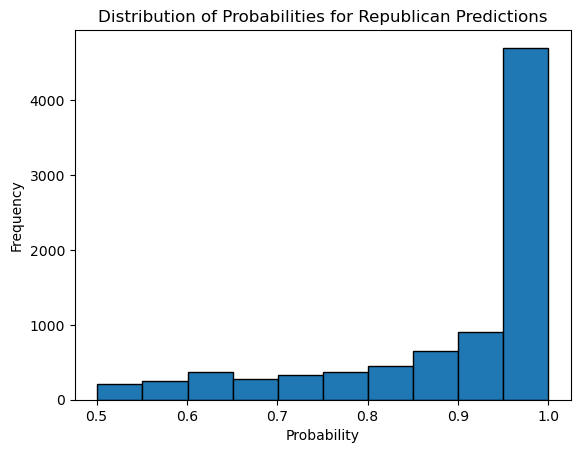

In [137]:
# Distribution of probabilites for Republican
republican_probs = tweet_text[tweet_text['estimated_party'] == 'Republican']['probability']

# Plot the histogram
plt.hist(republican_probs, bins=10, edgecolor='black')
plt.title('Distribution of Probabilities for Republican Predictions')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

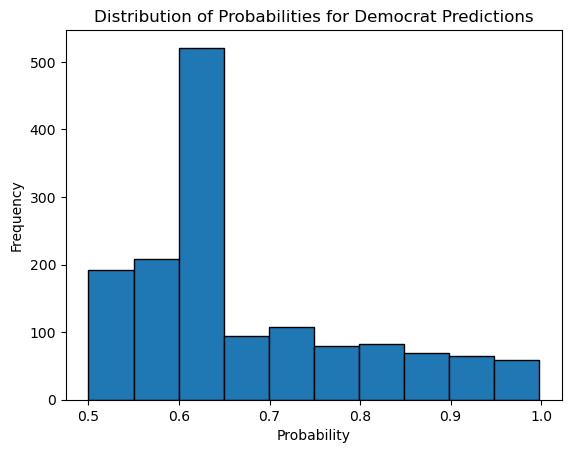

In [139]:
# Distributio of probabilities for Democrat
democrat_probs = tweet_text[tweet_text['estimated_party'] == 'Democratic']['probability']

# Plot the histogram
plt.hist(democrat_probs, bins=10, edgecolor='black')
plt.title('Distribution of Probabilities for Democrat Predictions')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

## Confusion matrix performance

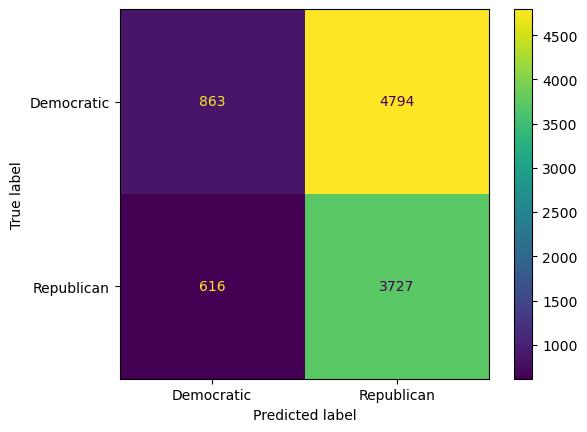

In [154]:
parties = ['Democratic','Republican']
# Confusion matrix for performance
conf_mat = confusion_matrix(y_true=tweet_text['party'], y_pred=tweet_text['estimated_party'], labels=parties)
conf_mat_display = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=parties)
conf_mat_display.plot()
plt.show()

In [155]:
precision = precision_score(y_true=tweet_text['party'], y_pred=tweet_text['estimated_party'], labels=parties, average='binary', pos_label='Republican')
recall = recall_score(y_true=tweet_text['party'], y_pred=tweet_text['estimated_party'], labels=parties, average='binary', pos_label='Republican')
accuracy = accuracy_score(y_true=tweet_text['party'], y_pred=tweet_text['estimated_party'])
precision, recall, accuracy

(0.43738997770214766, 0.8581625604420907, 0.459)

In [162]:
sensitivity = sensitivity_score(y_true=tweet_text['party'], y_pred=tweet_text['estimated_party'], labels=parties, average='binary', pos_label='Republican')
specificity = specificity_score(y_true=tweet_text['party'], y_pred=tweet_text['estimated_party'], labels=parties, average='binary', pos_label='Republican')
sensitivity, specificity

(0.8581625604420907, 0.1525543574332685)

# Reflections
The NB model performs quite well on the republican data because the language used at republican conferences is much more diverse and identifiable. The langauge used by democrats is very homogenous, so the algorithm had a hard time picking up on patterns to predict the democratic class.